In [1]:
.libPaths("~/R/prs-libs")
#.libPaths("/home/daniel/R/x86_64-pc-linux-gnu-library/4.2")
library(Sleuth2)
library(ggplot2)
library(eurostat)
library(vtable)
library(cowplot)
library(moments)
library(car)
library(olsrr)
library(plotly)
library(GGally)
library(Hmisc)

Loading required package: kableExtra

Loading required package: carData


Attaching package: ‘olsrr’


The following object is masked from ‘package:datasets’:

    rivers



Attaching package: ‘plotly’


The following object is masked from ‘package:ggplot2’:

    last_plot


The following object is masked from ‘package:stats’:

    filter


The following object is masked from ‘package:graphics’:

    layout


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: lattice

Loading required package: survival

Loading required package: Formula


Attaching package: ‘Hmisc’


The following object is masked from ‘package:plotly’:

    subplot


The following objects are masked from ‘package:base’:

    format.pval, units




In [2]:
#install.packages("plotly", dependencies=T, lib="/home/ivan/R/prs-libs")

In [3]:
#increase plot size
options(repr.plot.width = 15, repr.plot.height = 7)

# Analýza hrubého domácího produktu evropských zemí (v roce 2015)
## Úloha 1

### Příprava dat

Pomocí vzorce vypočítáme, pro jaký rok budeme řešit analýzu HDP evropských zemí.

In [4]:
K = 17
L = nchar("Dostal")
M = (((K + L) * 47) %% 11) + 1
year = 2011 + M
year

[1] 2015

Zajímat nás bude rok 2015, výpočet v tržních cenách v milionech eur. Nejprve se podíváme, jak data vypadají a kolik záznamů máme k dispozici.

In [5]:
dataset_id = "nama_10_gdp"
df = get_eurostat(id=dataset_id)
head(df)

Table nama_10_gdp cached at /tmp/RtmpwnPIQT/eurostat/nama_10_gdp_date_code_FF.rds



unit,na_item,geo,time,values
<chr>,<chr>,<chr>,<date>,<dbl>
CLV05_MEUR,B1G,AT,2022-01-01,283441.0
CLV05_MEUR,B1G,BA,2022-01-01,11427.6
CLV05_MEUR,B1G,BE,2022-01-01,355710.6
CLV05_MEUR,B1G,BG,2022-01-01,31876.7
CLV05_MEUR,B1G,CH,2022-01-01,445107.4
CLV05_MEUR,B1G,CY,2022-01-01,18712.1


Podíváme se dle čeho rozdělíme dataset.

In [6]:
unique(df$time)

[1] "2022-01-01" "2021-01-01" "2020-01-01" "2019-01-01" "2018-01-01"
 [6] "2017-01-01" "2016-01-01" "2015-01-01" "2014-01-01" "2013-01-01"
[11] "2012-01-01" "2011-01-01" "2010-01-01" "2009-01-01" "2008-01-01"
[16] "2007-01-01" "2006-01-01" "2005-01-01" "2004-01-01" "2003-01-01"
[21] "2002-01-01" "2001-01-01" "2000-01-01" "1999-01-01" "1998-01-01"
[26] "1997-01-01" "1996-01-01" "1995-01-01" "1994-01-01" "1993-01-01"
[31] "1992-01-01" "1991-01-01" "1990-01-01" "1989-01-01" "1988-01-01"
[36] "1987-01-01" "1986-01-01" "1985-01-01" "1984-01-01" "1983-01-01"
[41] "1982-01-01" "1981-01-01" "1980-01-01" "1979-01-01" "1978-01-01"
[46] "1977-01-01" "1976-01-01" "1975-01-01"

In [7]:
df = df[df$na_item=="B1GQ" & df$unit=="CP_MEUR" & df$time == "2015-01-01",]
#columns not needed
df$na_item = NULL
df$unit = NULL
df$time = NULL
#rename hdp column
names(df)[2] <- "hdp"
head(df)
cat("Number of rows: ", nrow(df))
cat("\nUnique location values:")
unique(df$geo)

geo,hdp
<chr>,<dbl>
AL,10264.1
AT,344269.2
BA,14791.1
BE,416701.4
BG,45812.3
CH,625532.7


Number of rows:  46
Unique location values:

[1] "AL"        "AT"        "BA"        "BE"        "BG"        "CH"       
 [7] "CY"        "CZ"        "DE"        "DK"        "EA"        "EA12"     
[13] "EA19"      "EA20"      "EE"        "EL"        "ES"        "EU15"     
[19] "EU27_2020" "EU28"      "FI"        "FR"        "HR"        "HU"       
[25] "IE"        "IS"        "IT"        "LI"        "LT"        "LU"       
[31] "LV"        "ME"        "MK"        "MT"        "NL"        "NO"       
[37] "PL"        "PT"        "RO"        "RS"        "SE"        "SI"       
[43] "SK"        "TR"        "UK"        "XK"

Zbylo nám 46 záznamů včetně evropských souhrnů více zemí (*EAx, EUx*). Ty si proto odebereme do druhého datasetu, jelikož tady pravděpodobně výrazně ovliňují souhrnné statistické míry - ty si zobrazíme pouze pro evropské země, kterých zde je 39.

In [8]:
group_df = subset(df, geo %in% c("EA", "EA12", "EA19", "EA20", "EU15", "EU27_2020", "EU28"))
df = subset(df, !(geo %in% c("EA", "EA12", "EA19", "EA20", "EU15", "EU27_2020", "EU28")))

### Průzkum dat

In [9]:
summ <- c('mean(x)', 'sd(x)', 'min(x)', 'pctile(x)[25]', 'median(x)', 'pctile(x)[75]', 
          'max(x)', 'IQR(x)', 'skewness(x)', 'kurtosis(x)-3')
sumtable(df, summ=summ, out="return")

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
hdp,428534.2,731663.323,3654.5,22601.75,160287.8,423268,3026180,400666.25,2.372,4.769


Ještě předtím, než začneme, je důležité zmínit, že zde uvedené HDP je celkové na celý stát, ne na obyvatele, jak se často také uvádí. Z toho plyne, že země s větším počtem obyvatel budou mít pravděpodobně větší HDP, jelikož k němu přispívá více lidí.

Průměrný HDP evropských zemí je 430 miliard eur, přičemž minimální pouhých 3.6 miliardy a maximální 3 biliony eur. Je vidět, že mezi jednotlivými zeměmi budou velmi výrazné rozdíly.
Standartní odchylka je 730 , dolní kvartil 22, horní 423 a medián 160 miliard eur. Medián je více než 2x menší než průměr a naznačuje, že pár zemí s velmi vysokým HDP (například Německo) potáhnou průměr nahoru. Tomu odpovídá i to, že průměr je vyšší než horní kvartil. Pravděpodobně to má za následek i šikmost, která vychází 2.4, což znamená, rozdělení je asymetrické a sešikmené směrem doprava a většina hodnot bude ležet pod průměrem.

Poměrně vysoká je také špičatost, takže v jedom místě bude koncentrováno velké množství hodnot.

Pro lepší znázornění rozdělení dat si zobrazíme histogram.

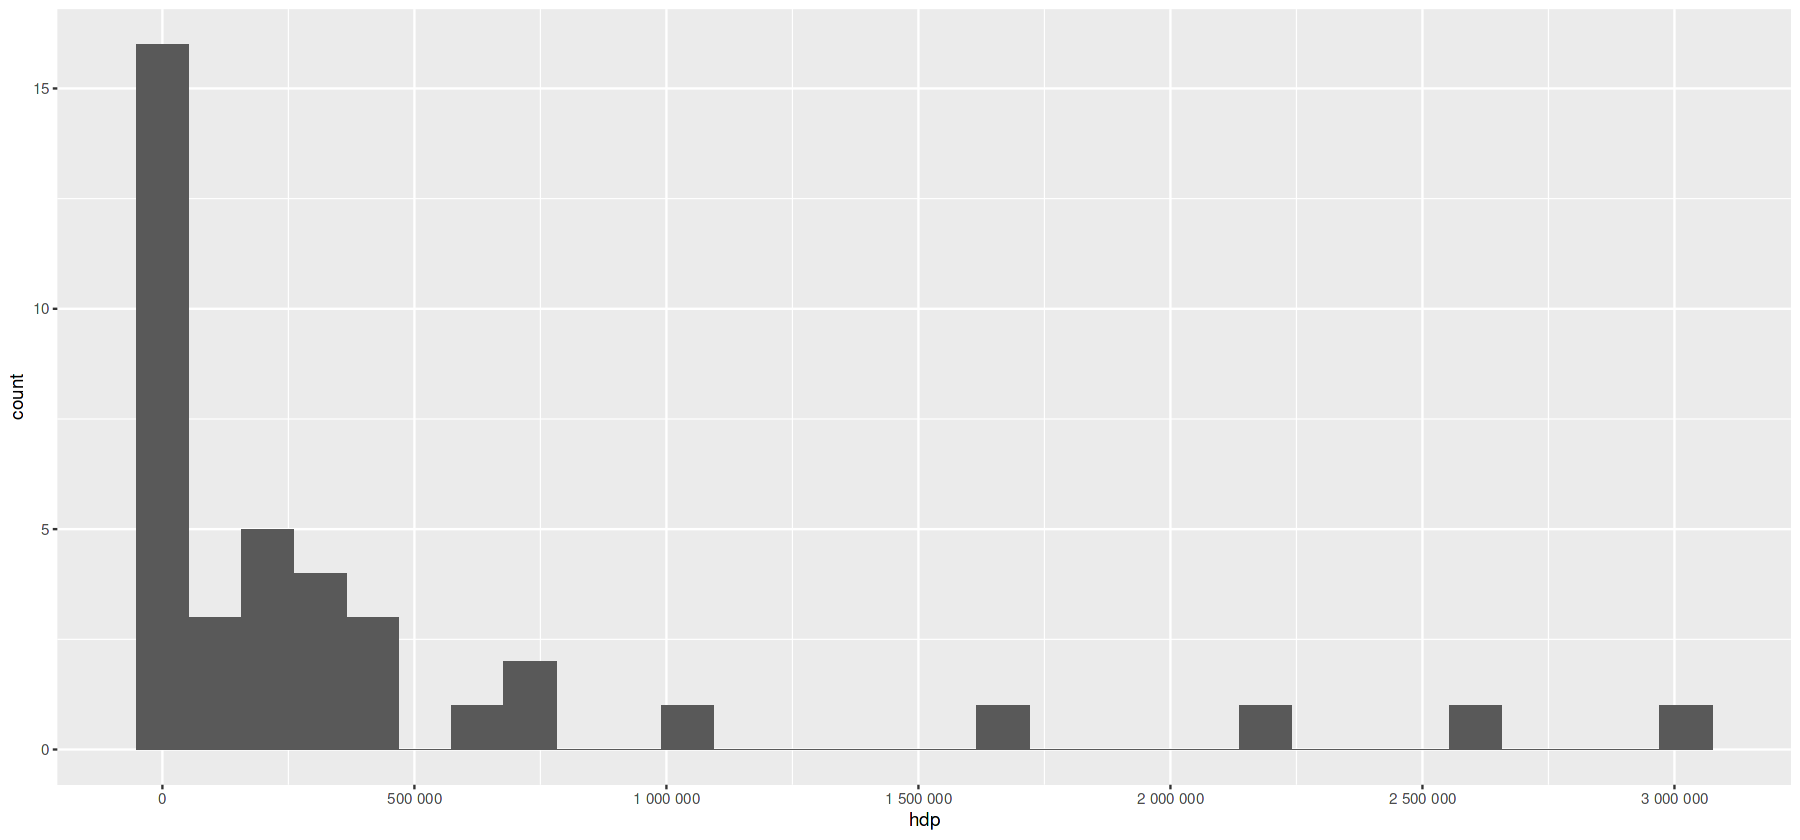

In [10]:
ggplot(df, aes(x=hdp)) + 
geom_histogram(bins=30) +
scale_x_continuous(labels = scales::number, n.breaks=8)

Histogram trochu připomíná exponenciální rozdělení. To bude způsobeno tím, že většina zemí má HDP poměrně nízké v porovnání s pár velkými, výrazně ekonomicky rozvinutějšími zeměmi v Evropě (Německo, Británie, Francie, Itálie), které mají HDP řádově vyšší, ale kterých je zase na druhou stranu výrazně méně.

### Faktory ovlivňující HDP

Dále nás zajímá, které konkrétní údaje by mohly mít vliv na výši HDP evropských zemích a pomocí kterých údajů by bylo možné HDP nejlépe predikovat. 

Jak jsme zmínili již výše, tím, že HDP je zde počítáno na celý stát a ne na obyvatele, tak důležitým faktorem bude určitě počet obyvatel dané země. I přesto, že malé státy jako například Lucembursko nebo Belgie mají v Evropě jeden z nejvyšších HDP na osobu, tak tím, že mají málo obyvatel, jejich celkové HDP bude nízké v porovnání s méně ekonomicky rozvinutými zeměmi, které ale mají výrazně víc obyvatel.

Samotný počet obyvatel ale nemusí být sám o sobě úplně vypovídající. Mohou existovat země, které mají velké procento populace ekonomicky neaktivní nebo málo vzdělané, což by pravděpodobně vedlo k tomu, že budou mít nižší HDP než země s podobným počtem obyvatel, ale mladší a vzdělanější populací. HDP tedy bude záviset i na faktorech jako je průměrný věk, vzdělanost (gramotnost), nezaměstnanost, úmrtnost nebo výše kriminality.

Na HDP by mohla mít vliv také průměrná mzda v dané zemi. Dávalo by smysl, kdyby země s vyšší průměrnou mzdou měly vyšší HDP. Také bude zajímavé prozkoumat, jestli členství v EU má vliv na výši HDP. Výhody a dotace, které členství v EU umožňuje, by ho mohly zvyšovat.

Dále by HDP mohla ovlivnit geografická poloha státu nebo průměrná teplota. Země s moc vysokou nebo moc nízkou průměrnou teplotou často bývají méně produktivní, takže teplotní extrémy by mohly mít negativní vliv.

Zajímavé by bylo také zkoumat závislost HDP na pozici státu v evropských žebříčcích hodnotících míru korupce, míru demokracie, svobodu projevu nebo nezávislost veřejnoprávních medií. Mohli bychom doufat, že státy, které mají v těchto žebříčcích "lepší" postavení, budou lépe fungovat a jejich HDP bude tím pádem vyšší.

## Úloha 2
### Výběr čtyř konkrétních faktorů

Výše jsme sice uvedli několik údajů, které mohou mít na HDP vliv, a určitě existuje plno dalších, které jsme nezmínili. V této práci si ale vybereme pouze čtyři z nich, které nám přijdou zajímavé nebo které podle nás budou mít na HDP největší vliv (nebo s ním budou nejvíce korelovat). Tyto údaje dále použijeme jako regresory v modelu pro jeho predikci.

#### 1. Populace

Prvním vybraným údajem bude populace. Tu získáme z eurostat datasetu *Population on 1 January*.

In [11]:
population_df = get_eurostat(id="tps00001")

Table tps00001 cached at /tmp/RtmpwnPIQT/eurostat/tps00001_date_code_FF.rds



Vybereme pouze data z roku 2015 a smažeme z datasetu nepotřebné sloupce.

In [12]:
population_df = subset(population_df, time == "2015-01-01")
population_df$indic_de = NULL
population_df$time = NULL
#rename column
names(population_df)[2] <- "population"
head(population_df)
cat("\nUnique location values:")
cat(unique(population_df$geo))

geo,population
<chr>,<dbl>
AL,2885796
AM,3010598
AT,8584926
AZ,9593038
BA,3825334
BE,11237274



Unique location values:AL AM AT AZ BA BE BG BY CH CY CZ DE DK EA19 EE EL ES EU27_2020 FI FR GE HR HU IE IS IT LI LT LU LV MC MD ME MK MT NL NO PL PT RO RS SE SI SK SM TR UA UK XK

Opět odstraníme souhrnné skupiny více evropských zemí a dataset spojíme s původním datasetem obsahujícím HDP.

In [13]:
population_df = subset(population_df, !(geo %in% c("EA", "EA12", "EA19", "EA20", "EU15", "EU27_2020", "EU28")))
df = merge(df, population_df,by="geo")
#test if there are any missing values that failed to join correctly
cat("Number of NA values in 'geo' and 'population' columns:")
sum(is.na(population_df$geo))
sum(is.na(population_df$population))

Number of NA values in 'geo' and 'population' columns:

[1] 0

[1] 0

Zobrazíme si základní popisné statistiky počtu obyvatel evropských zemí.

In [14]:
sumtable(subset(df, select = "population"), out="return", summ=summ)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
population,15854063.4,23246813.276,37366,2066023,5659715,11047646,81197537,8981623,1.784,1.724


Průměrná populace je 15.8 milionů obyvatel. Oproti tomu medián je pouhých 5.6 milionů. To stejně jako u HDP značí, že pár zemí s výrazně vyšším počtem obyvatel zvedá průměr nahoru. Stejně tak je vidět, že průměr je i výrazně nad horním kvartilem, který je pouhých 11 milionů. S tím pravděpodobně souvisí i šikmost, která je 1.8 a naznačuje, že většina hodnot bude opět ležet pod průměrem a data budou sešikmená směrem do prava.

Zobrazíme si i histogram pro lepší názornost.

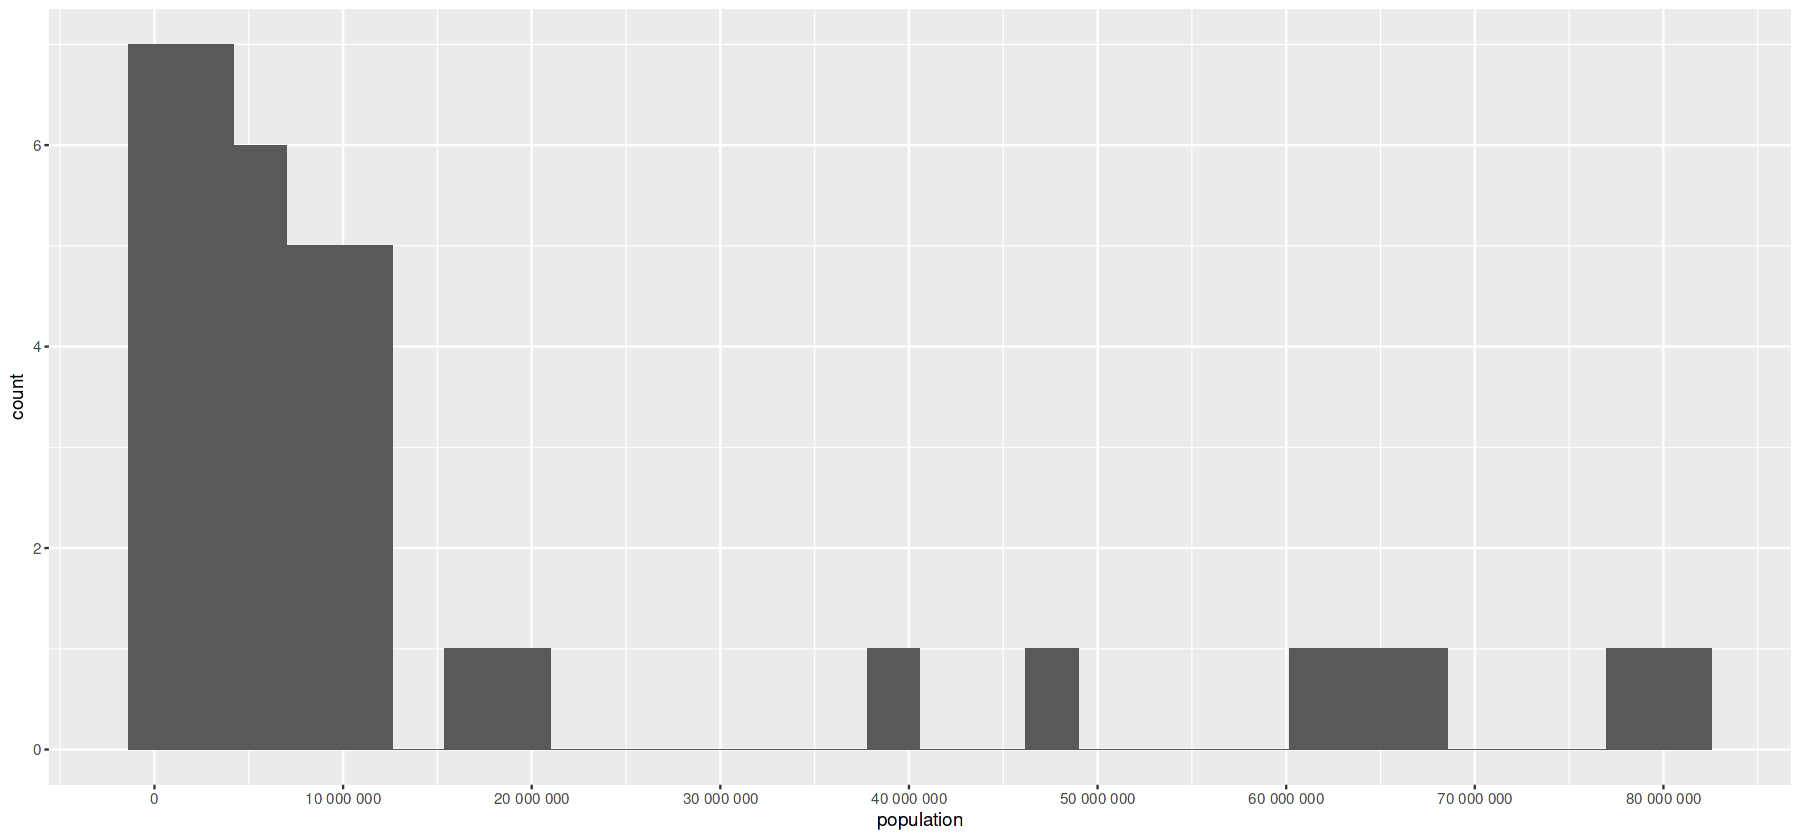

In [15]:
ggplot(df, aes(x=population)) + 
geom_histogram(bins=30) +
scale_x_continuous(labels = scales::number, n.breaks=8)

Histogram vypadá do jisté míry podobně jako u HDP. Většina evropských zemí má méně než 12 milionů obyvatel, ale existuje několik vyjímek, které mají populaci násobně vyšší.

Podobnost rozdělení dat by mohla znamenat, že populace a HDP spolu budou korelovat. Tuto skutečnost ověříme.

In [16]:
cor(df$hdp, df$population)

[1] 0.8848981

Opravdu tomu tak je. HDP a počet obyvatel mají silnou pozitivní korelaci. S růstem počtu obyvatel roste i HDP. To dává smysl, protože jak jsme zmiňovali už párkrát výše, větší počet obyvate znamená, že více lidí může pracovat a vydělávat státu peníze.

#### 2. Členství v Evropské unii

Jako další údaj, který máme pocit že by mohl mít vztah k HDP, jsme si zvolili členství v EU. Jelikož se jedná o kategorickou proměnnou a členských států EU v roce 2015 je pouze 28, přidáme je do datasetu ručně.

In [17]:
eu_members = c("BE", "BG", "CZ", "DK", "DE", "EE", "IE", "EL", "ES", "FR", "HR", "IT", "CY", "LV", "LT", "LU", "HU", 
                 "MT", "NL", "AT", "PL", "PT", "RO", "SI", "SK", "FI", "SE", "UK")
length(eu_members)

[1] 28

In [18]:
df$eu_member = ifelse(df$geo %in% eu_members, 1, 0)
#check values are if correctly added
head(df)
sum(df$eu_member)
#transform to factor variable
df$eu_member <- as.factor(df$eu_member)

,geo,hdp,population,eu_member
,<chr>,<dbl>,<dbl>,<dbl>
1,AL,10264.1,2885796,0
2,AT,344269.2,8584926,1
3,BA,14791.1,3825334,0
4,BE,416701.4,11237274,1
5,BG,45812.3,7202198,1
6,CH,625532.7,8237666,0


[1] 28

Ověříme, jestli mezi členství v EU a HDP je nějaký vztah. Zobrazíme si *boxplot*, u kterého omezíme měřítko u HDP, aby byl graf lépe vidět. Na grafu potom sice neuvidíme odlehlé hodnoty, ale ty nás teď tolik nezajímají.

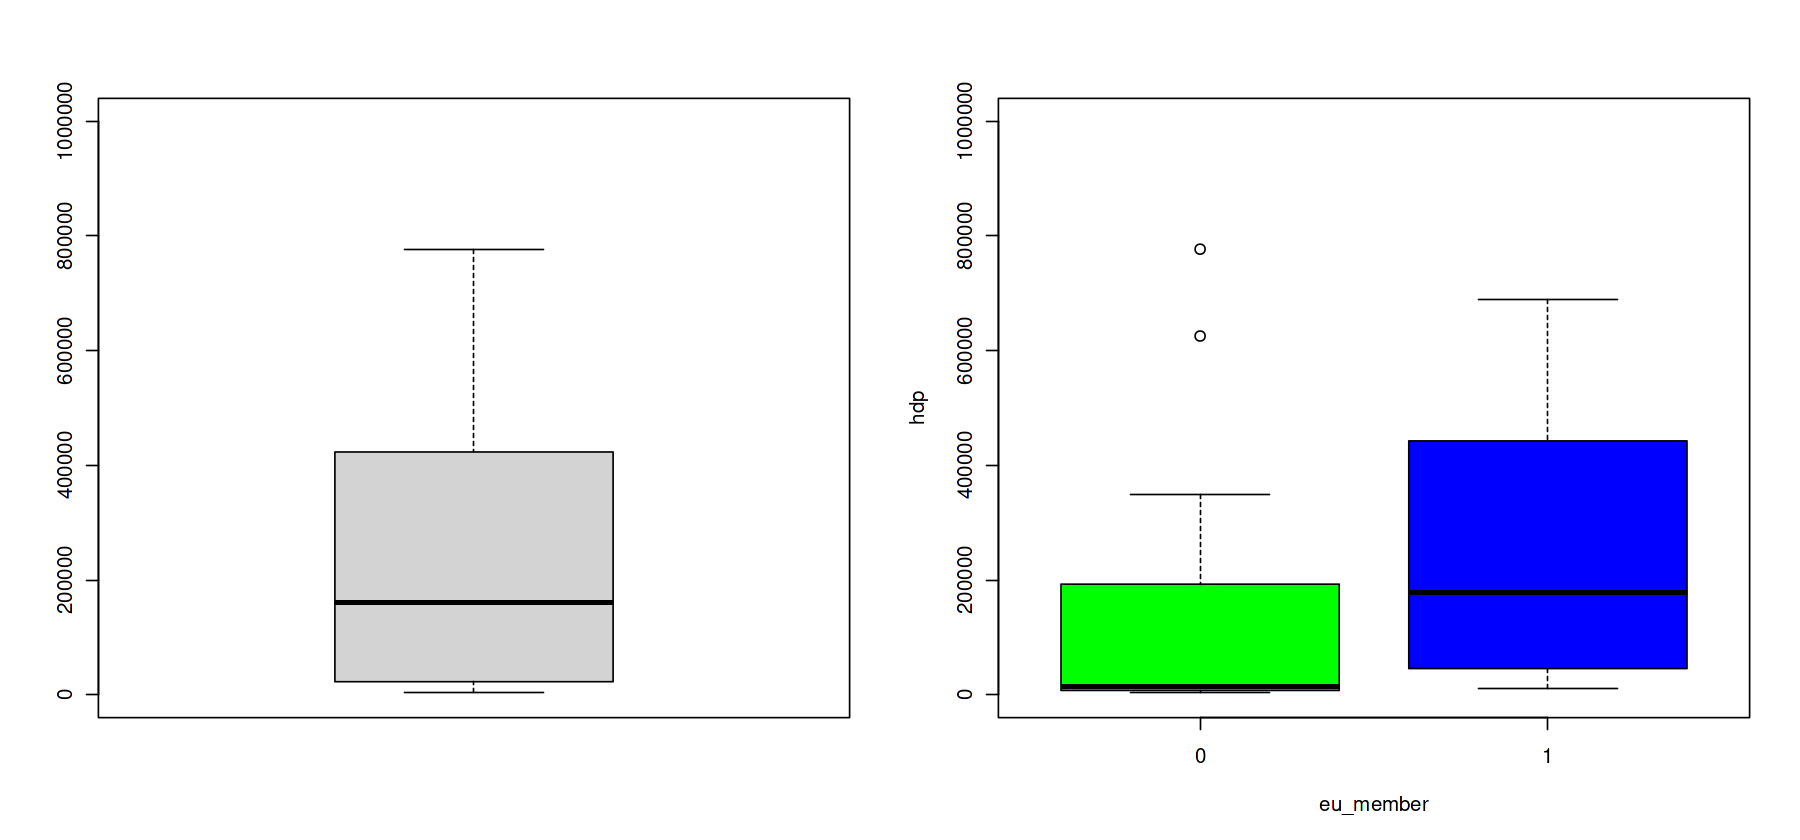

In [19]:
par(mfrow=c(1,2))
boxplot(df$hdp, ylim = c(0, 1000000))
boxplot(hdp~eu_member,col=c("green","blue"), data=df, ylim = c(0, 1000000))
options(scipen=5)

Je vidět, že závislost mezi členství v EU a HDP existuje. Státy, které v nejsou v Evropské unii mají medián výrazně nižší než členské státy EU. Dolní kvartil je u obou skupin podobný, ale horní kvartil je u členských států také výrazně vyšší.

Zobrazíme si data pro porovnání i v číslech.

In [20]:
by(df$hdp,df$eu_member,summary)

df$eu_member: 0
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   3654    7373   14791  168452  192748  777042 
------------------------------------------------------------ 
df$eu_member: 1
   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   9997   45674  178041  530709  436250 3026180 

Čísla odpovídají grafům výše. Medián u členských státu je více než 10x vyšší než u států mimo EU a horní kvartil více než 2x.

#### 3.Průměrná cena práce
Jako další regresor jsme si vybrali průměrnou cenu práce, vyjádřenou jako *průměrný počet EUR za hodinu*. Využijeme předpřipravený dataset stažený z eurostatu - id *lc_lci_lev*. Data jsou až z roku 2016 jelikož se dříve dělal průzkum jednou za 4 roky, ale to by nemělo mít velký vliv. Data si dopřipravíme - odebereme souhrnné skupiny států, vybereme sloupce a připojíme je ke zbytku dat.  

In [21]:
salary_df = read.csv("labour_costs.csv")
salary_df = salary_df[,c("geo", "OBS_VALUE")]
salary_df = subset(salary_df, !(geo %in% c("EA", "EA12", "EA19", "EA20", "EU15", "EU27_2020", "EU28")))
names(salary_df)[2] <- "labour_cost"
df = merge(df, salary_df, by="geo", all.x=TRUE)

Po spojení zkontroluji, zda mi nechybí nějaké hodnoty.

In [22]:
df[is.na(df$labour_cost),]

,geo,hdp,population,eu_member,labour_cost
,<chr>,<dbl>,<dbl>,<fct>,<dbl>
21,LI,5649.1,37366,0,NA
39,XK,5674.4,1804944,0,NA


Údaje o platu chybí Lichtenštejnsku a Kosovu. Lichtenštejnsku doplníme stejnou cenu práce jako má Švýcarsko, protože jsou v obou zemích velmi podobné platové podmínky, obě země využívají Švýcarský frank a jsou spolu v celní unii. Kosovo by na tom co se týká platů mělo být podobně jako jeho sousedé Albánie a Severní Makedonie.

In [23]:
df[df$geo=="LI",]$labour_cost = df[df$geo=="CH",]$labour_cost
df[df$geo=="XK",]$labour_cost = (df[df$geo=="AL",]$labour_cost + df[df$geo=="MK",]$labour_cost) / 2

In [24]:
sumtable(subset(df, select = "labour_cost"), out="return", summ=summ)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
labour_cost,16.6,12.507,2.1,5.6,12.9,25.7,44.4,20.1,0.696,-0.644


Průměrná cena práce není již tak extrémně vychýlená jako celkové HDP či populace. Je to tím, že je zprůměrovaná a nemá na ní moc vliv velikost státu. Vychýlení zde způsobují hlavně bohaté státy, jejichž obyvatelé mají vysokou cenu práce. Také je tento regresor rovnoměrněji rozdělený a jeho rozdělení není tak špičaté.

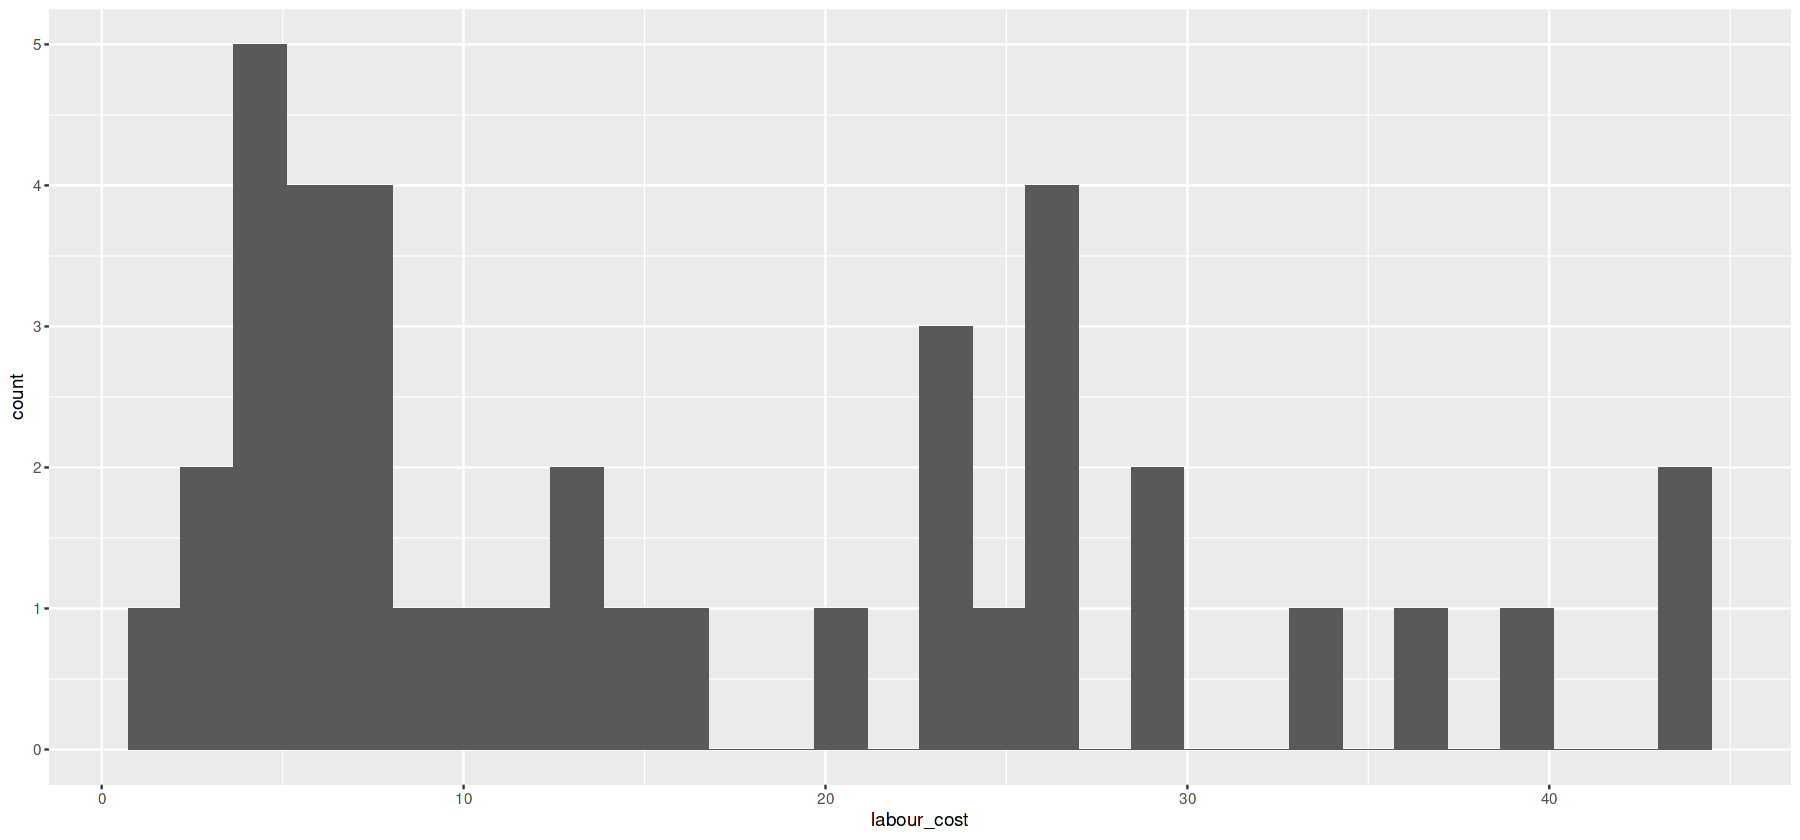

In [25]:
ggplot(df, aes(x=labour_cost)) + 
geom_histogram(bins=30) +
scale_x_continuous(labels = scales::number, n.breaks=8)

In [26]:
cor(df$hdp, df$labour_cost, use="complete.obs")

[1] 0.2758993

Průměrná cena práce příliš nekoreluje s celkovým HDP, ale stejně může přispět k lepším výsledkům modelu tím, že pomůže rozlišit stejně veliké, ale odlišně bohaté státy. 

#### 4. Korupce

Jako poslední regresor použijeme index vnímání korupce sestrojovaný agenturou Transparency international, který se pokouší o stanovení míry zkorumpovanosti veřejných sektorů jednotlivých států. Hodnoty se pohybují na škále od 0 do 100, kde 0 znamená vysokou míru korupce a 100 velmi férové prostředí. Vybereme data jen z roku 2015 a opět se zbavíme skupin států.

In [27]:
corruption_df = get_eurostat(id="sdg_16_50")
corruption_df = subset(corruption_df, time == "2015-01-01")
corruption_df = corruption_df[,c("geo", "values")]
corruption_df = subset(corruption_df, !(geo %in% c("EA", "EA12", "EA19", "EA20", "EU15", "EU27_2020", "EU28")))
names(corruption_df)[2] <- "corruption"
df = merge(df, corruption_df, by="geo", all.x=TRUE)

Table sdg_16_50 cached at /tmp/RtmpwnPIQT/eurostat/sdg_16_50_date_code_FF.rds



In [28]:
df[is.na(df$corruption),]

,geo,hdp,population,eu_member,labour_cost,corruption
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
3,BA,14791.1,3825334,0,4.8,NA
21,LI,5649.1,37366,0,44.4,NA
39,XK,5674.4,1804944,0,2.8,NA


Informace o korupci se nepodařilo sehnat v Bosně, Lichtenštejnsku a Kosovu. Na internetu [lze dohledat](https://www.transparency.org/en/cpi/2015), že index vnímání korupce v Bosně v roce 2015 byl 38 a v Kosovu 33. Lichtenštejnsko v tomto indexu nefiguruje, ale v ukazateli Control of corruption má v roce 2015 výsledek 2.06 (má jiné měřítko než námi používaný index), což je skoro stejné jako výsledky Lucemburska a Singapuru (2.09). Obě tyto země měly v indexu vnímání korupce v roce 2015 hodnotu 85. Lucembursku tedy doplníme hodnotu 84.

In [29]:
df[df$geo=="LI",]$corruption = 84
df[df$geo=="BA",]$corruption = 38
df[df$geo=="XK",]$corruption = 33

sumtable(subset(df, select = "corruption"), out="return", summ=summ)

Variable,Mean,Sd,Min,Pctile[25],Median,Pctile[75],Max,IQR,Skewness,Kurtosis-3
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
corruption,62.8,17.963,33,46,60,80,91,34,0.067,-1.338


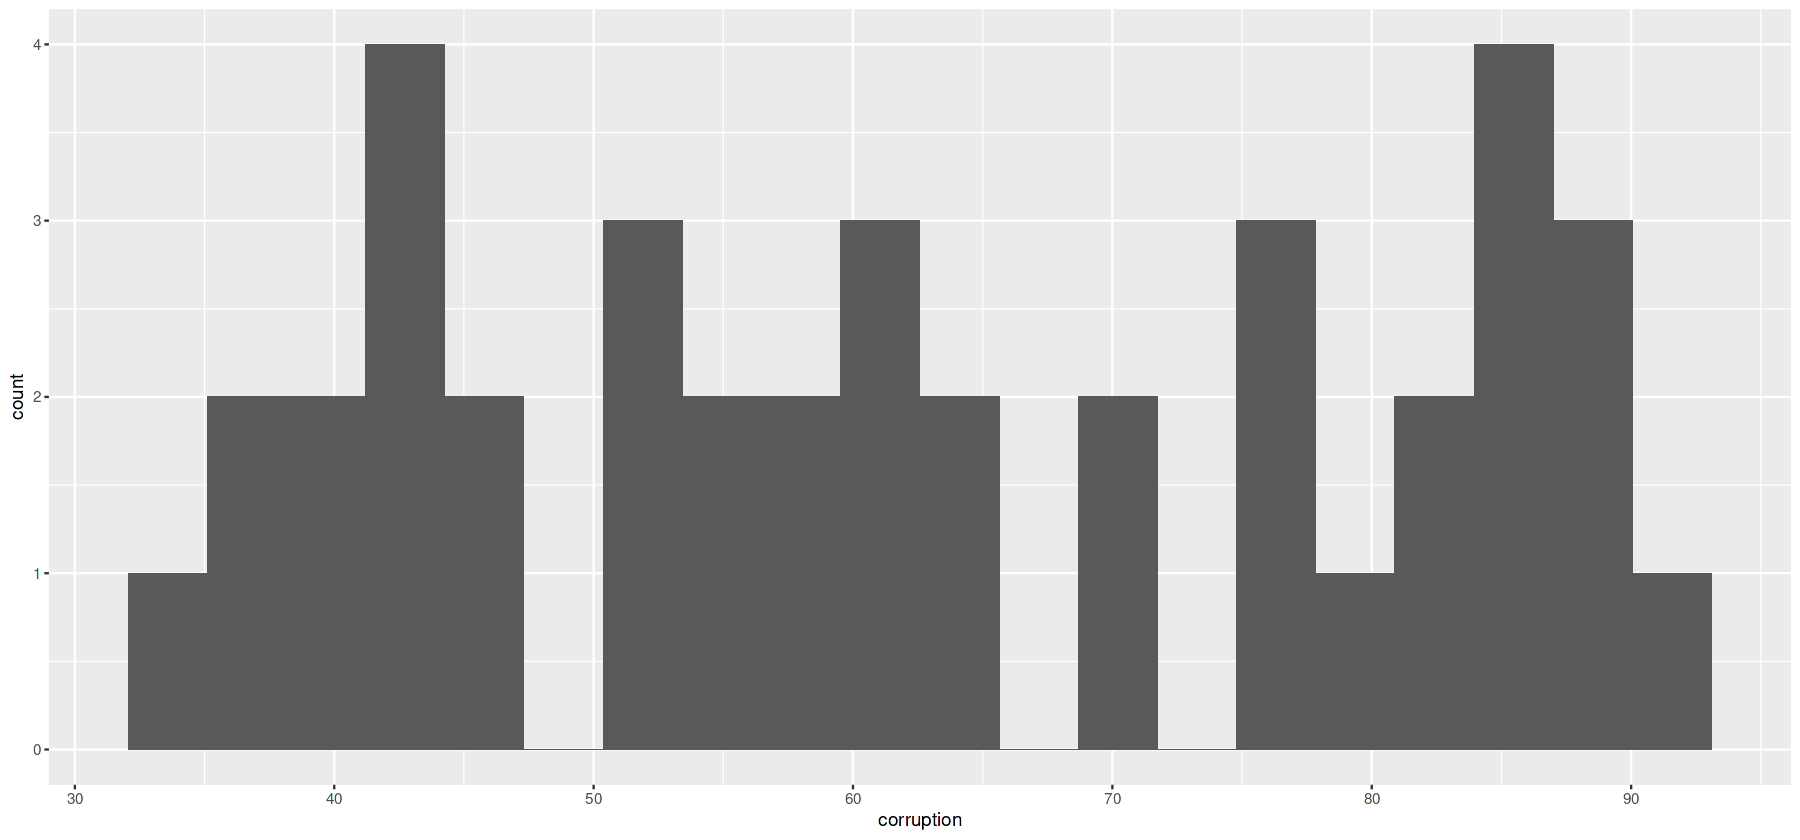

In [30]:
ggplot(df, aes(x=corruption)) + 
geom_histogram(bins=20) +
scale_x_continuous(labels = scales::number, n.breaks=8)

Data o korupci jsou docela vyvážená, nejblíže mají asi k rovnoměrnému rozdělení. Příjemné překvapení je docela vysoký průměr a medián, většina států se umístila na horní polovině této škály.

In [31]:
cor(df$hdp, df$corruption, use="complete.obs")

[1] 0.2666113

Korupce má nízkou pozitivní korelaci s HDP. Do jisté míry tedy platí, že státy s menší mírou korupce mají vyšší HDP (vyšší číslo v indexu korupce znamená menší míra korupce).

### Otestování závislostí mezi regresory

Zatím jsme zkoumali pouze závislost HDP a vybraných regresorů, ale ne jak závisí jednotlivé regresory mezi sebou. Zobrazíme si tedy ještě korelační matici a podíváme se na vztahy mezi nimi.

In [32]:
#check correlation between numerical variables only
cor(subset(df, select=c("hdp", "population", "labour_cost", "corruption")))

,hdp,population,labour_cost,corruption
hdp,1.0000000,0.88489810,0.27589931,0.26661130
population,0.8848981,1.00000000,0.04713873,0.02168331
labour_cost,0.2758993,0.04713873,1.00000000,0.87121324
corruption,0.2666113,0.02168331,0.87121324,1.00000000


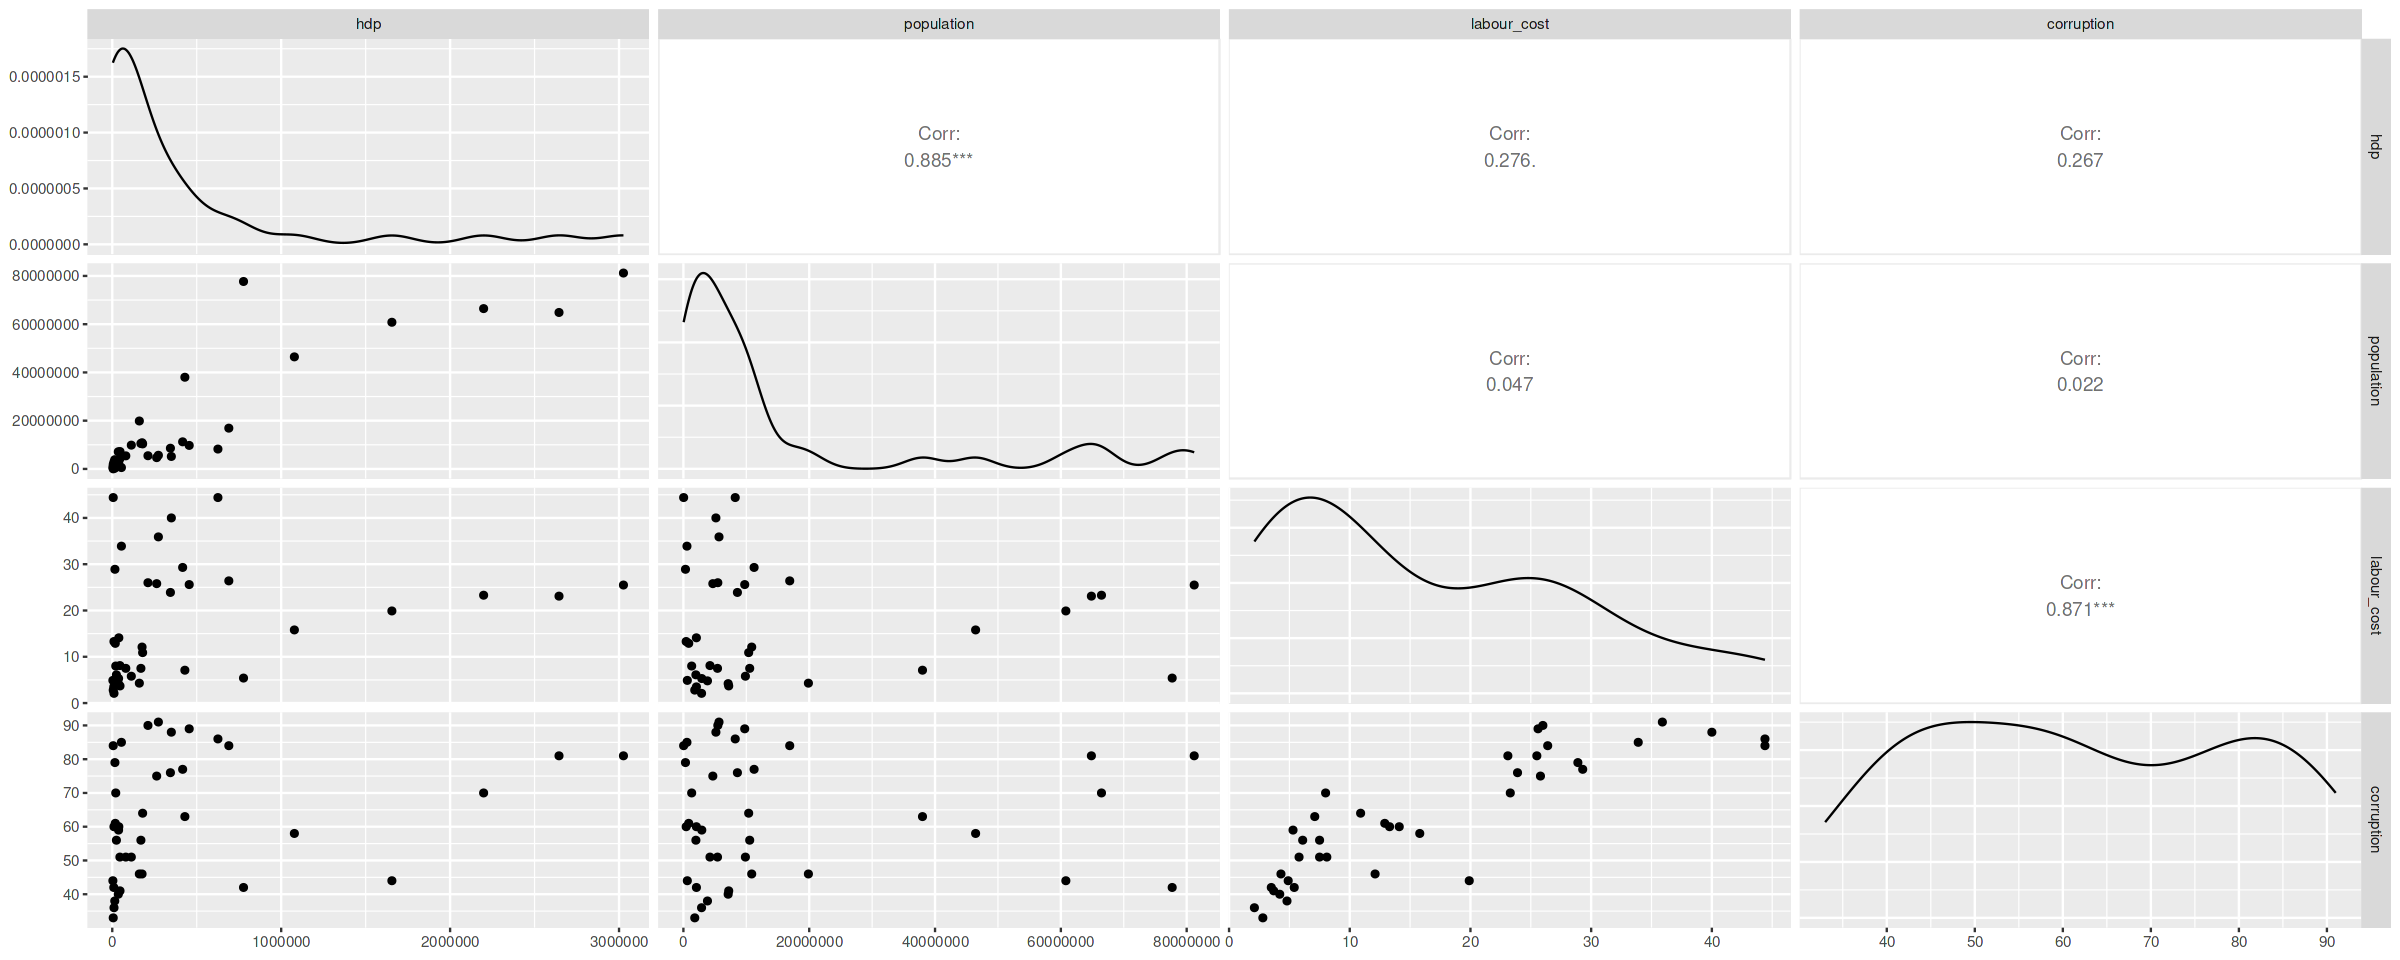

In [33]:
options(repr.plot.width = 20, repr.plot.height = 8)
p = ggpairs(subset(df, select=c("hdp", "population", "labour_cost", "corruption"))) 
p

In [34]:
#set scale bac
options(repr.plot.width = 15, repr.plot.height = 7)

Populace koreluje pouze s HDP, ale mezi cenou práce a korupčním indexem je vysoká pozitivní korelace. Z toho plyne, že v zemích, které mají méně korupce, je průměrná cena práce vyšší.

Takto vysoká korelace mezi regresory by mohla být problémová při vytváření modelu a možná budeme muset použít robustnější model nebo jeden z korelovaných regresorů z modelu odstranit.

Je také vidět znatelná šimost populace a HDP, později může být výhodné je zlogaritmovat. Vidíme, že cena práce a index korupce s nimi moc dobře nekorelují, což může být způsobeno právě onou šikmostí.

Ještě na závěr otestujeme korelace mezi proměnnými.

In [35]:
res <- rcorr(as.matrix(subset(df, select=c("hdp", "population", "labour_cost", "corruption"))))
round(res$P, 3)

,hdp,population,labour_cost,corruption
hdp,NA,0.000,0.089,0.101
population,0.000,NA,0.776,0.896
labour_cost,0.089,0.776,NA,0.000
corruption,0.101,0.896,0.000,NA


Vidíme, že testy potrvdily naše předchozí domněnky. Zamítáme, že HDP nekoreluje s populací a že cena práce nekoreluje s korupcí. U ostatních proměnných ale nekorelovanost připouštíme.

### Regresní model pro jednotlivé proměnné

Začneme postupně a nejprve se podíváme, jak by vypadaly predicke pomocí jednotlivých regresorů. Neprve pro populaci.

In [36]:
fit_population = lm(hdp~population, df)
summary(fit_population)


Call:
lm(formula = hdp ~ population, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1373850   -87475    -5583   117469   851501 

Coefficients:
                Estimate   Std. Error t value Pr(>|t|)    
(Intercept) -13017.62156  67219.69713  -0.194    0.848    
population       0.02785      0.00241  11.556 7.72e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 345400 on 37 degrees of freedom
Multiple R-squared:  0.783,	Adjusted R-squared:  0.7772 
F-statistic: 133.5 on 1 and 37 DF,  p-value: 7.724e-14


Samotná populace vysvětluje HDP poměrně dobře. Hodnota adjustovaného koeficientu determinace je 0.77. Odhad HDP pro stát s nulovou populací je -13 miliard eur. Hodnota se může zdát poněkud zvláštní, ale odhadovat HDP země, která má nulovou populaci, nedává moc smysl. S každým 100 obyvatel se hodnota dále zvedá o 2.78 milonů eur.

Warning message in predict.lm(fit_population, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


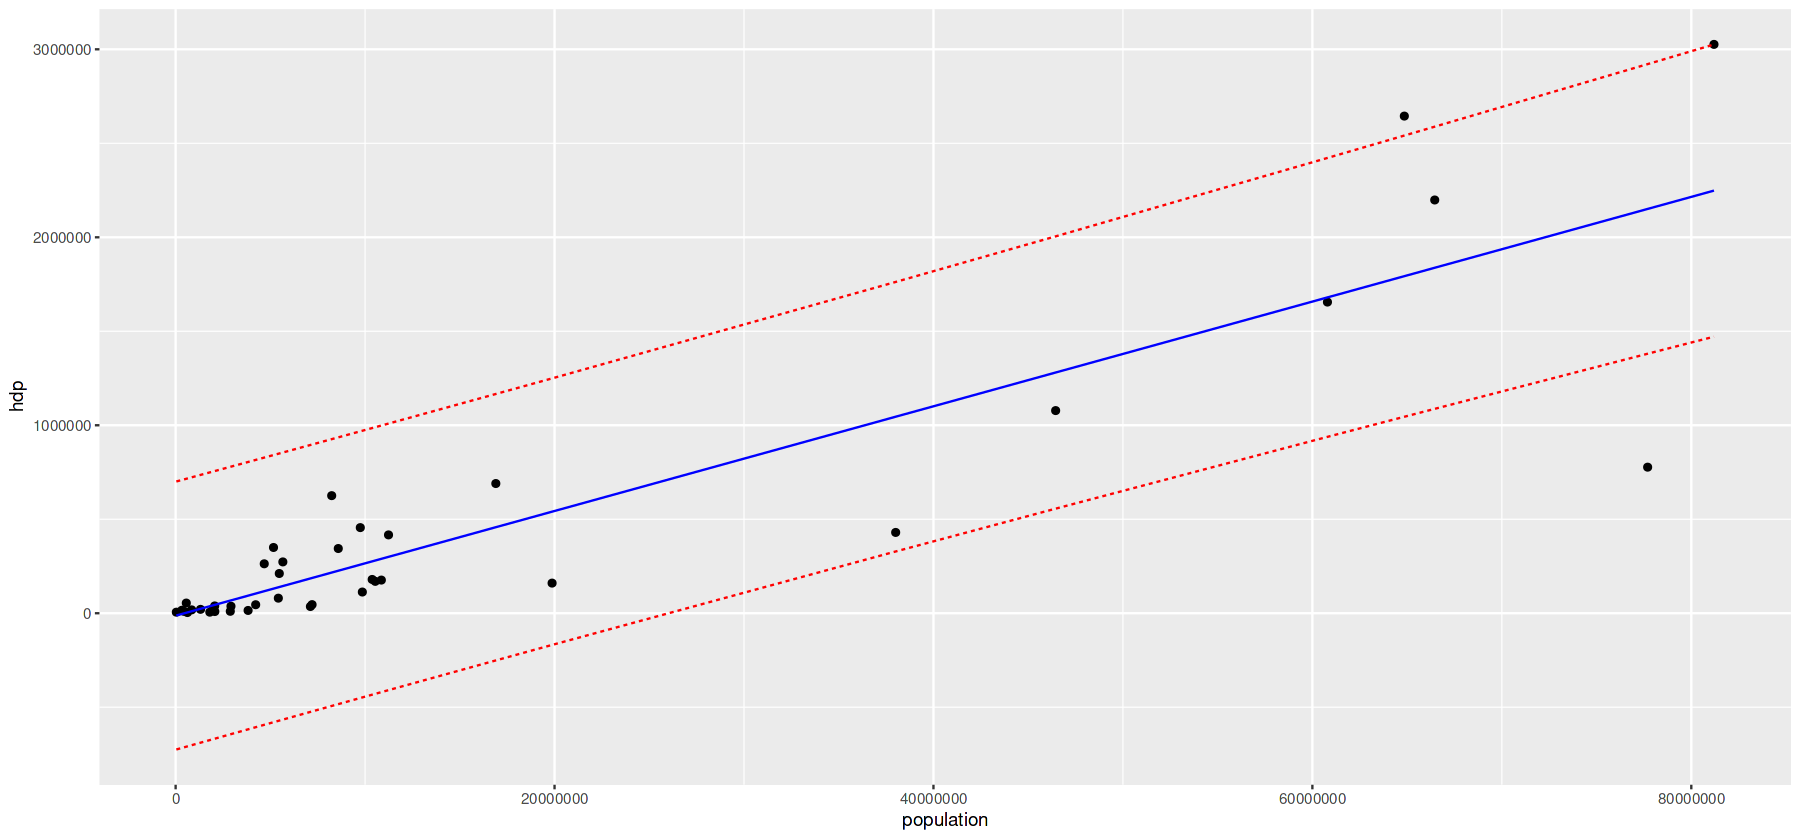

In [37]:
tmp = predict(fit_population, interval="prediction")
df_pop = cbind(df, tmp)
ggplot(df_pop, aes(x=population, y=hdp)) +
    geom_point() +
    geom_line(aes(y=fit), color="blue") +
    geom_line(aes(y=lwr), color = "red", linetype = "dashed") +
    geom_line(aes(y=upr), color = "red", linetype = "dashed")

Z grafu je hned na první pohled vidět, že problémové budou odlehlé hodnoty - státy s velmi vysokou populací. I relativně malá změna u těchto států může znamenat "natočení" celé predikční přímky a výraznou změnu v predikcích pro ostatní země.

Dále k populaci zkusíme přidat i faktorovou proměnnou určující členství v Evropské unii.

In [38]:
fit_pop_eu = lm(hdp~population*eu_member, df)
summary(fit_pop_eu)


Call:
lm(formula = hdp ~ population * eu_member, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-766322  -92203  -18123  115879  548257 

Coefficients:
                            Estimate     Std. Error t value    Pr(>|t|)    
(Intercept)             72456.621830   81161.899738   0.893     0.37809    
population                  0.009618       0.003415   2.816     0.00793 ** 
eu_member1            -150765.781371  100203.143021  -1.505     0.14140    
population:eu_member1       0.023916       0.003959   6.041 0.000000681 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 244300 on 35 degrees of freedom
Multiple R-squared:  0.8973,	Adjusted R-squared:  0.8885 
F-statistic:   102 on 3 and 35 DF,  p-value: < 2.2e-16


Tato úprava výslednou přesnost výrazně zlepšila. Ajustovaný koeficient determinace se zvýšil na necelých 0.89.

Oba intercepty (predikce pro nulovou populaci pro státy v/mimo EU) vycházejí nevýznamně. Závislost mezi HDP a členstvím v EU je ale poměrně vysoká, jelikož pro členské státy roste HDP s populací více než dvakrát tak rychle jako pro státy mimo EU. U členských států s každým 100 obyvatel predikce HDP vzroste o 2.39 milionů eur, kdežto u států, které nepatří do Evropské unie, pouze o 0.96.

Warning message in predict.lm(fit_pop_eu, interval = "prediction"):
“predictions on current data refer to _future_ responses
”


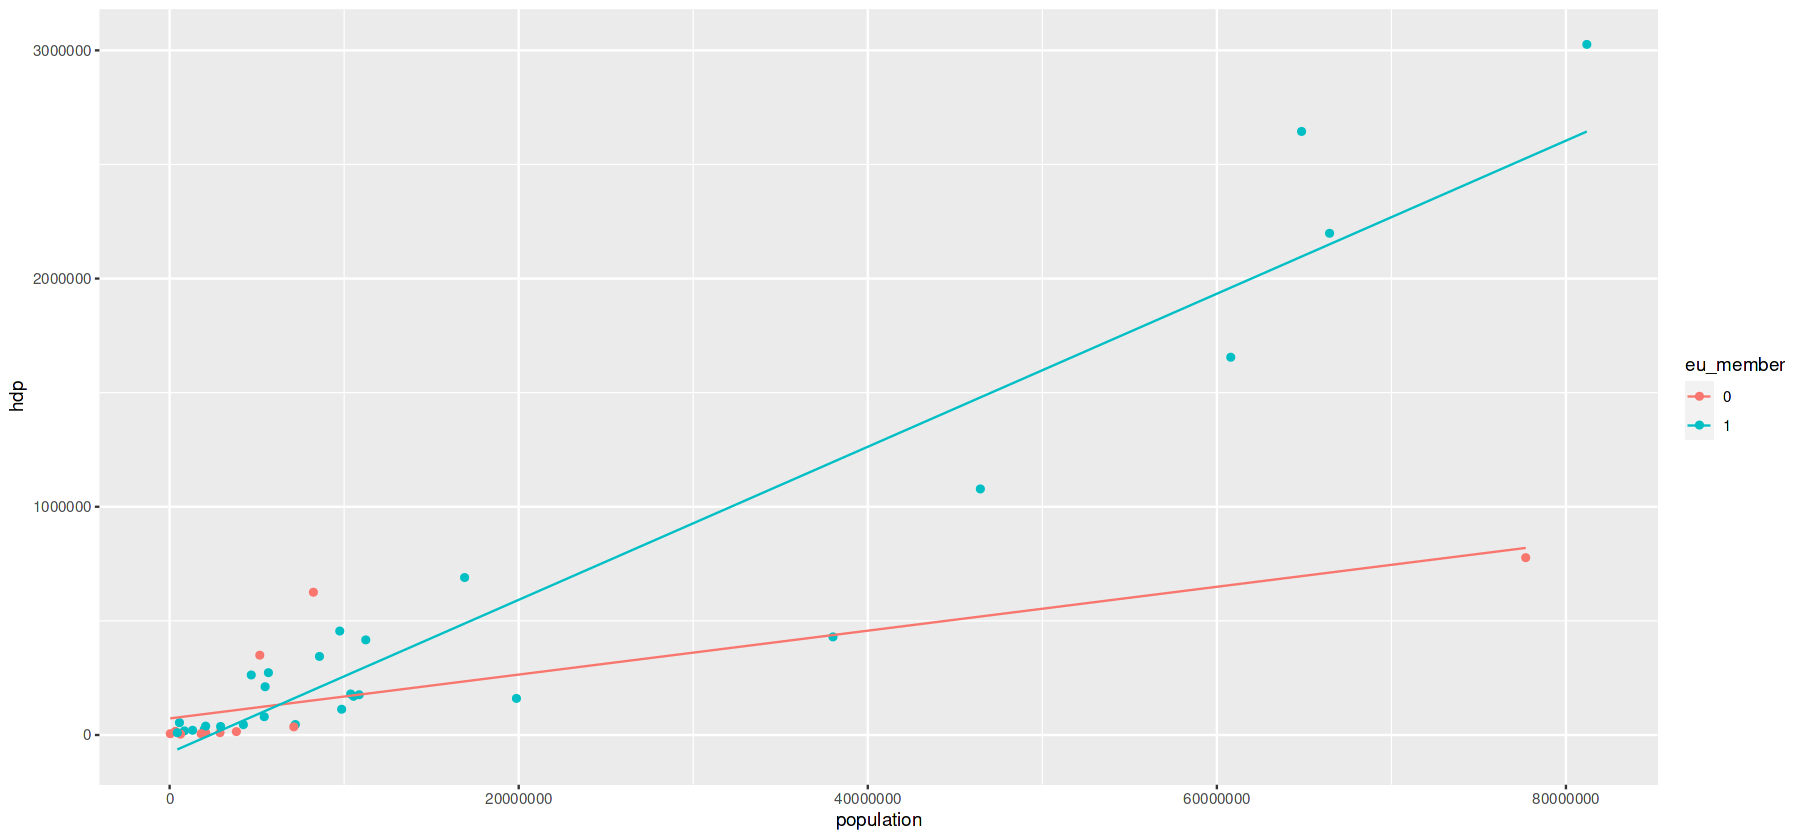

In [39]:
tmp = predict(fit_pop_eu, interval="prediction")
df_pop_eu = cbind(df, tmp)
ggplot(df_pop_eu, aes(x=population, y=hdp, group=eu_member, color=eu_member)) +
    geom_point() +
    geom_line(aes(y=fit))

Stejně jako u samotné populace nastává problém s odlehlými hodnotami. Například sklon predikční přímky pro státy mimo EU je zde určen v podstatě jediným státem, který má populaci blížící se 80 milionům (Turecko). Pokud by se HDP tohto státu relativně málo změnilo, ovlivní to všechny ostatní predikce pro státy mimo EU.

Zajímavé pozorování je, že až na vyjímku Turecka, jsou všechny velké státy s vysokým HDP v Evropské unii.

Jako další se podíváme, jak moc lze HDP vysvětlit pouze pomocí průměrné ceny práce nebo míry korupce.

In [40]:
fit_labour = lm(hdp~labour_cost, df)
summary(fit_labour)

fit_corruption = lm(hdp~corruption, df)
summary(fit_corruption)


Call:
lm(formula = hdp ~ labour_cost, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-871948 -291945 -202459 -115573 2453628 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   160984     191065   0.843   0.4049  
labour_cost    16140       9244   1.746   0.0891 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 712700 on 37 degrees of freedom
Multiple R-squared:  0.07612,	Adjusted R-squared:  0.05115 
F-statistic: 3.049 on 1 and 37 DF,  p-value: 0.08911



Call:
lm(formula = hdp ~ corruption, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-653446 -351517 -193913  -78096 2399664 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)  -253124     420966  -0.601    0.551
corruption     10860       6454   1.683    0.101

Residual standard error: 714600 on 37 degrees of freedom
Multiple R-squared:  0.07108,	Adjusted R-squared:  0.04598 
F-statistic: 2.831 on 1 and 37 DF,  p-value: 0.1009


Samotná cena práce ani míra korupce očivnidně s celkovým HDP příliš nesouvisí. Bude to pravděpodobně proto, že i když mají některé státy velmi nízkou míru korupce a vysokou cenu práce, ale jsou malé s nízkým počtem obyvatel (Lucembursko, Belgie, Nizozemsko), tak jejich celkové HDP nebude nijak vysoké. V kombinaci s populací by ale tyto údaje mohly mít podstatný vliv.

## Úloha 3
### Model lineární regrese pro více regresorů
Nejprve vytvoříme jednoduchý model bez interakcí.

In [41]:
fit_basic = lm(hdp~population + eu_member +labour_cost+ corruption, df)
summary(fit_basic)


Call:
lm(formula = hdp ~ population + eu_member + labour_cost + corruption, 
    data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-1082753   -83843    -2655    90790   716797 

Coefficients:
                  Estimate     Std. Error t value Pr(>|t|)    
(Intercept) -494393.164001  258500.963956  -1.913   0.0643 .  
population        0.027265       0.002158  12.633 2.14e-14 ***
eu_member1    96864.751902  130394.872761   0.743   0.4627    
labour_cost    8074.392229    9263.327085   0.872   0.3895    
corruption     4576.712083    6657.599873   0.687   0.4965    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 301300 on 34 degrees of freedom
Multiple R-squared:  0.8482,	Adjusted R-squared:  0.8304 
F-statistic:  47.5 on 4 and 34 DF,  p-value: 1.856e-13


Koeficient u regresoru *population* je zde statisticky významný. Z předešlých poznatků je to pochopitelné. Ostatní koeficienty ale vychází nevýznamně. Použijeme `vif`, abychom otestovali, jak moc je který regresor závislý na ostatních.

In [42]:
vif(fit_basic)

population   eu_member labour_cost  corruption 
   1.053344    1.478685    5.617031    5.984489

Faktor zvětšení rozptylu je malý pro populaci a členství v EU. Pro míru korupce a cenu práce vycházejí hodnoty vyšší a z tohoto modelu bychom je tedy měli odebrat. Než to ale uděláme, vyzkoušíme, jestli model výrazně nezlepší přidání interakcí.

Interakce přidáme mezi všechny proměnné, abychom otestovali co nejvíce různých závislostí. 

In [43]:
fit_all = lm(hdp~population*eu_member*labour_cost*corruption, df)
summary(fit_all)


Call:
lm(formula = hdp ~ population * eu_member * labour_cost * corruption, 
    data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-129018  -13056    -339    3333  285598 

Coefficients:
                                                    Estimate      Std. Error
(Intercept)                                  -14520.90422717 375421.49085226
population                                        0.00873368      0.23452962
eu_member1                                   112293.56127333 471340.34259415
labour_cost                                  -28670.66327804 125103.58085356
corruption                                     1963.87447147  13044.89986144
population:eu_member1                            -0.02989882      0.23575947
population:labour_cost                            0.00805140      0.02747554
eu_member1:labour_cost                        25192.21468545 126299.84208860
population:corruption                            -0.00066385      0.00616800
eu_member1:corruption       

Adjustovaný koeficient determinace vychází sice dost vysoký, ale model je velmi složitý a nulovost všech koeficientů vychází nevýznamně. Zkusíme proto model zjednodušit.

Jak už jsme několikrát zmiňovali, nejdůležitějším údajem bude pravděpodobně populace a proto zkusíme použít interakce pouze mezi populací a ostatními proměnnými a ty poté sečíst.

In [44]:
fit2 = lm(hdp~population*eu_member + population*labour_cost + population*corruption, df)
summary(fit2)


Call:
lm(formula = hdp ~ population * eu_member + population * labour_cost + 
    population * corruption, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-155189  -13260   -1349   13531  295939 

Coefficients:
                             Estimate     Std. Error t value Pr(>|t|)    
(Intercept)            -5101.53476617 84860.43673039  -0.060   0.9524    
population                -0.00343651     0.00236092  -1.456   0.1556    
eu_member1              5880.20418854 40577.99270835   0.145   0.8857    
labour_cost              909.53937794  3097.22101270   0.294   0.7710    
corruption               -91.15608939  2297.62414544  -0.040   0.9686    
population:eu_member1     -0.00245737     0.00200335  -1.227   0.2292    
population:labour_cost     0.00124238     0.00012799   9.707 6.49e-11 ***
population:corruption      0.00016283     0.00005964   2.730   0.0103 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 71440 on 31 d

Koeficient determinace zůstal téměř beze změny a adjustovaný koeficient se oproti předchozímu modelu zvýšil a přesáhl hodnotu 0.99. Model už není zdaleka tak složitý, ale významně vychází pouze koeficienty *population:labour_cost* a *population:corruption*.

Kombinace *population:labour_cost* je vlastně odhadem průměrného hodinového výdělku celého státu, respektive všech jeho obyvatel, což bude mít s celkovým HDP poměrně úzkou souvislost.

Koeficient u regresoru *population:corruption* vychází 0.00016. Tento regresor uvádí počet obyvatel přeškálovaný mírou korupce. Můžeme se na to dívat tak, že státům, kteří mají vyšší index korupce (mají menší míru korupce), se jejich populace "zvětší" oproti státům, které mají index nižší.

Nyní zkusíme model postupně zjednodšovat a odebírat nevýznamné regresory. Odebírat budeme prvně regresory neobsahující interakce s populací, jelikož to vypadá, že ty nemají na výslednou predkci velký vliv. Začneme s regresorem *eu_member*.

In [45]:
fit3 = lm(hdp~population:eu_member + population*labour_cost + population*corruption, df)
summary(fit3)


Call:
lm(formula = hdp ~ population:eu_member + population * labour_cost + 
    population * corruption, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-154743  -14262   -3846   13303  295973 

Coefficients:
                              Estimate      Std. Error t value Pr(>|t|)    
(Intercept)            -10622.31346684  74658.89643762  -0.142   0.8878    
population                 -0.00332267      0.00219208  -1.516   0.1394    
labour_cost               645.01524676   2463.54911626   0.262   0.7951    
corruption                126.80477617   1710.10706821   0.074   0.9414    
population:eu_member1      -0.00230184      0.00166551  -1.382   0.1765    
population:labour_cost      0.00124375      0.00012567   9.897 2.92e-11 ***
population:corruption       0.00015908      0.00005291   3.007   0.0051 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 70340 on 32 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-sq

Adjustovaný koeficient determinace se nepatrně zvýšil a koeficienty regresorů, které předtím vycházely nevýznamně, vychází nevýznamně pořád.

Budeme pokračovat v redukci modelu odebráním regresoru *corruption*.

In [46]:
fit4 = lm(hdp~population:eu_member + population*labour_cost + population:corruption, df)
summary(fit4)


Call:
lm(formula = hdp ~ population:eu_member + population * labour_cost + 
    population:corruption, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-155036  -14428   -3598   13090  295654 

Coefficients:
                             Estimate     Std. Error t value Pr(>|t|)    
(Intercept)            -5377.19805825 23518.71925472  -0.229 0.820564    
population                -0.00341935     0.00173539  -1.970 0.057234 .  
labour_cost              807.35831661  1112.31217691   0.726 0.473055    
population:eu_member1     -0.00228571     0.00162619  -1.406 0.169199    
population:labour_cost     0.00123956     0.00011055  11.212 8.55e-13 ***
population:corruption      0.00016158     0.00004023   4.016 0.000321 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 69270 on 33 degrees of freedom
Multiple R-squared:  0.9922,	Adjusted R-squared:  0.991 
F-statistic: 841.2 on 5 and 33 DF,  p-value: < 2.2e-16


Adjustovaný koeficient determinace se opět mírně zvýšil a koeficienty regresorů bez interakce s populací zůstaly stejně nevýznamné. Dále odebereme regresor *labour_cost*.

In [47]:
fit5 = lm(hdp~population:eu_member + population:labour_cost + population:corruption, df)
summary(fit5)


Call:
lm(formula = hdp ~ population:eu_member + population:labour_cost + 
    population:corruption, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-163397  -13965   -7423   15522  294679 

Coefficients:
                             Estimate     Std. Error t value Pr(>|t|)    
(Intercept)             8535.35061374 13533.27897636   0.631 0.532458    
population:eu_member0     -0.00368926     0.00168325  -2.192 0.035344 *  
population:eu_member1     -0.00640419     0.00225079  -2.845 0.007464 ** 
population:labour_cost     0.00128001     0.00009481  13.501 3.22e-15 ***
population:corruption      0.00015976     0.00003987   4.007 0.000318 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 68790 on 34 degrees of freedom
Multiple R-squared:  0.9921,	Adjusted R-squared:  0.9912 
F-statistic:  1066 on 4 and 34 DF,  p-value: < 2.2e-16


Teď už vychází nevýznamně pouze intercept. Dáva celkem smysl, aby intercept byl nulový, jelikož v základním stavu při nulovosti ostatních regresorů (například stát s nulovou populací) by HDP mělo být blízké nule. Intercept proto také odebereme.

In [48]:
fit6 = lm(hdp~population:eu_member + population:labour_cost + population:corruption - 1, df)
summary(fit6)


Call:
lm(formula = hdp ~ population:eu_member + population:labour_cost + 
    population:corruption - 1, data = df)

Residuals:
    Min      1Q  Median      3Q     Max 
-167692   -6912     514   22649  291781 

Coefficients:
                          Estimate  Std. Error t value Pr(>|t|)    
population:eu_member0  -0.00353283  0.00165049  -2.140 0.039362 *  
population:eu_member1  -0.00612753  0.00218856  -2.800 0.008266 ** 
population:labour_cost  0.00127240  0.00009323  13.649  1.4e-15 ***
population:corruption   0.00016069  0.00003950   4.068 0.000256 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 68190 on 35 degrees of freedom
Multiple R-squared:  0.9941,	Adjusted R-squared:  0.9934 
F-statistic:  1470 on 4 and 35 DF,  p-value: < 2.2e-16


Nyní již všechny regresory vychází významně a koeficient determinace dosahuje dokonce vyšší hodnoty, než u složitého modelu se všemi možnými interakcemi.

Nakonec se v modelu vyskytují všechny původní údaje v kombinaci s počtem obyvatel. Závislost na HDP není tak jednoduše vysvětlitelná, jako u jednoduchého modelu bez interakcí, protože se tu kombinuje větší množství proměnných.

Koeficienty u regresorů *population:eu_member0* a *population:eu_member1* nám říkají, že za každých 1000 obyvatel se musí odečíst zhruba 6 milionů eur pro státy v EU a přibližně 3.5 milionů eur pro státy mimo EU. Tento vztah je poměrně překvapivý, jelikož jsme čekali, že tomu bude spíše naopak (členství v EU bude HDP zvyšovat). Může to ale být tím, že i mimo EU jsou poměrně bohaté země, jako Norsko či Švýcarsko a i Turecko, které je velmi početné a má tedy vysoké HDP.
Jelikož jsme z modelu odebrali intercept, začíná HDP na 0 a s rostoucím počtem obyvatel se odečítají hodnoty spojené s členstvím v EU a přičítají hodnoty podle míry korupce a ceny práce.

Pomocí příkazu `anova` provedeme F-test a ověříme, jestli se původní složitý model dá redukovat na tento zjednodušený model. Zároveň si zobrazíme informační kritéria všech modelů.

In [49]:
anova(fit6, fit_all)
AIC(fit_all, fit2, fit3, fit4, fit5, fit6)
BIC(fit_all, fit2, fit3, fit4, fit5, fit6)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,162766454277,NA,NA,NA,NA
2,23,149284935236,12,13481519042,0.173089,0.9985011


,df,AIC
,<dbl>,<dbl>
fit_all,17,1005.2341
fit2,9,991.5016
fit3,8,989.5280
fit4,7,987.5347
fit5,6,986.1524
fit6,5,984.6060


,df,BIC
,<dbl>,<dbl>
fit_all,17,1033.5146
fit2,9,1006.4736
fit3,8,1002.8365
fit4,7,999.1796
fit5,6,996.1338
fit6,5,992.9238


Hypotézu, že počáteční model lze redukovat na jednodušší, nezamítáme. Zároveň je výsledný model nejlepší i podle obou informačních kritérií.

### Odlehlá pozorování
Na předchozích grafech jsme několikrát pozorovali odlehlé hodnoty, které by mohly způsobovat problémy při predikci. Pro lepší přehled se podíváme na Cookovu vzdálenost pro náš model.

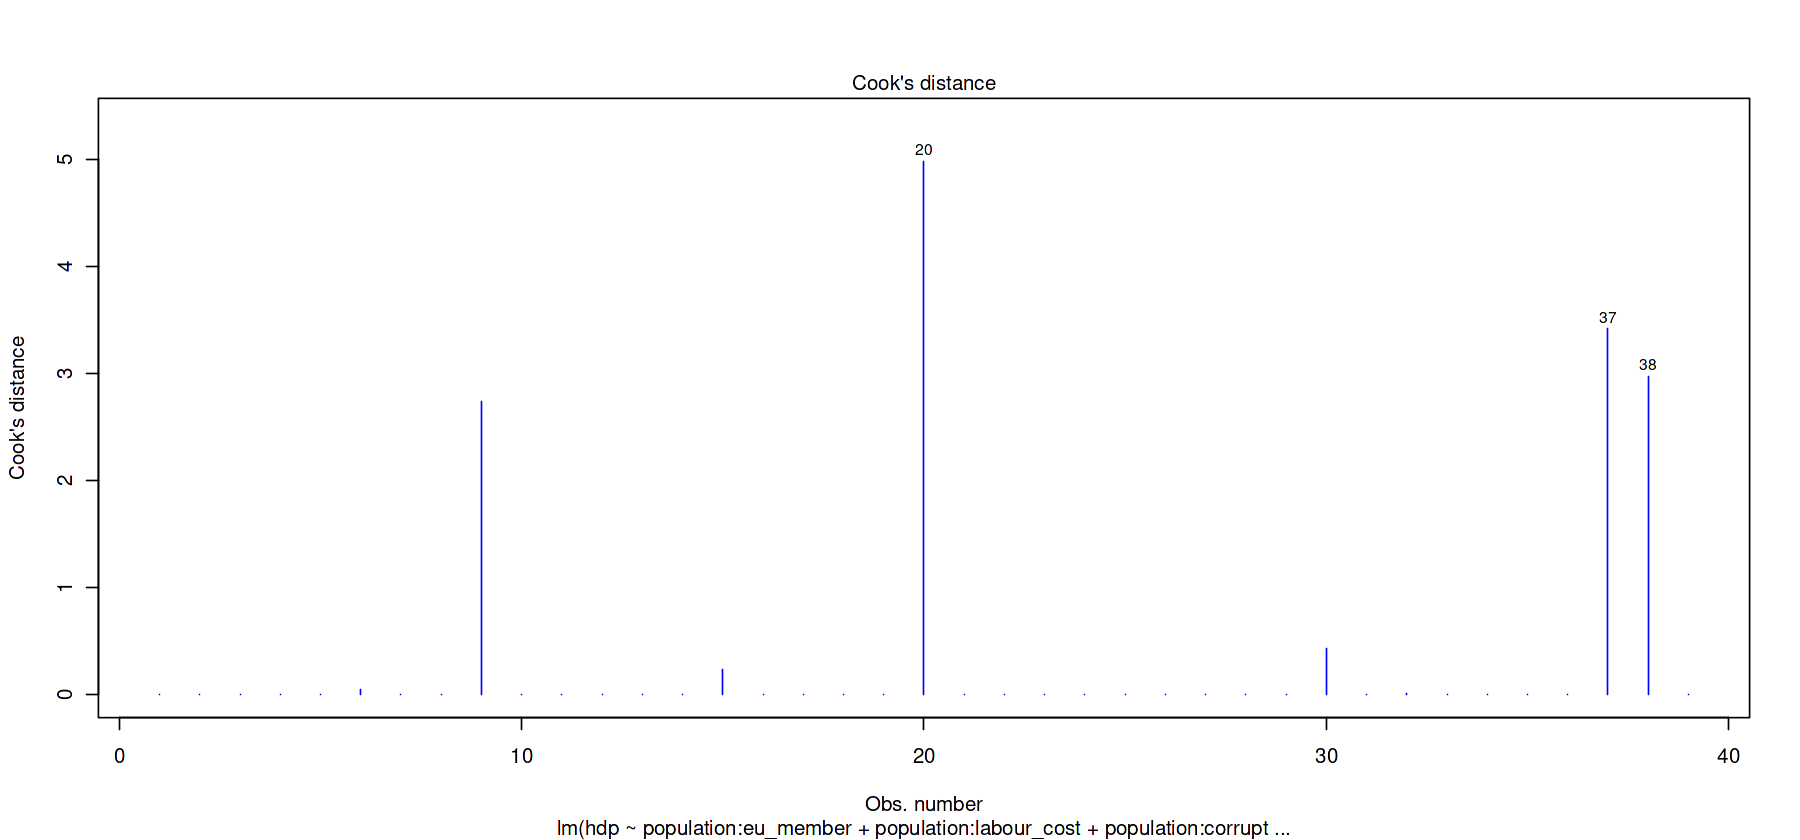

In [50]:
plot(fit6, which=4, col=c("blue"))

A opravdu, parametry modelu závisí výhradně na 4 konkrétních státech a změna jejich HDP by znamenala pravděpodobně výraznou změnu parametrů modelu.

Tyto země si zobrazíme.

In [51]:
df[c(9, 20, 37, 38),]

,geo,hdp,population,eu_member,labour_cost,corruption
,<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>
9,DE,3026180.0,81197537,1,25.5,81
20,IT,1655355.0,60795612,1,19.9,44
37,TR,777042.3,77695904,0,5.4,42
38,UK,2644716.5,64853393,1,23.1,81


Jedná se o Německo, Itálii, Turecko a Británii. Všechno jsou to země s nejvyšším počtem obyvatel a HDP v Evropě. Jejich odebráním by se možná zlepšila schopnost modelu predikovat HDP u zemí s menším počtem obyvatel, ale na druhou stranu by nefungoval model tak dobře pro větší státy. Zároveň je také možné, že kvůli tomu, že histogram populace lehce připomínal exponenciální rozdělení, tak by se v novém měřítku vyskytovaly další země, které by vůči ostatním působily jako odlehlé hodnoty. Záznamy proto ponecháme beze změny.

### Heteroskedasticita dat
Dále otestujeme heteroskedasticitu šumu. Podíváme se, jestli máme proměnlivou varianci residuí, nejprve pomocí vhodného grafu.

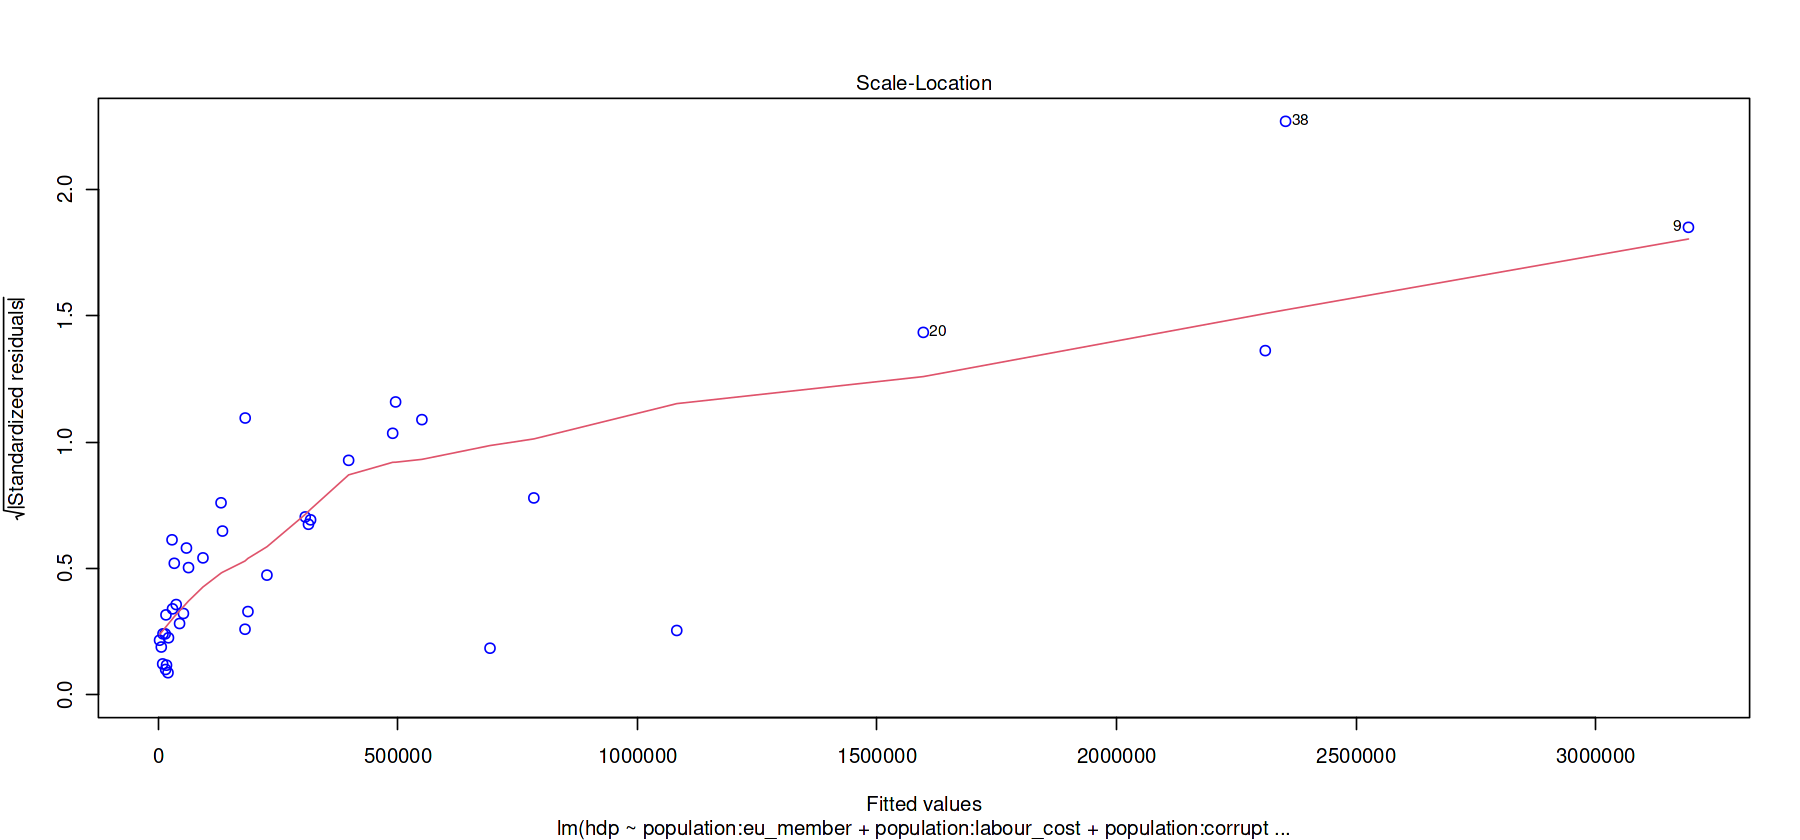

In [52]:
plot(fit6, which=3, col=c("blue"))

Z grafu to vypadá, že residua nemají stejný rozptyl. Pro země s nízkým HDP je variance residuí mnohem menší, než pro země s vysokým HDP.

Heteroskedasticitu ověříme pomocí Breusch Pagan testu.

In [53]:
ols_test_breusch_pagan(fit6)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

             Data               
 -------------------------------
 Response : hdp 
 Variables: fitted values of hdp 

         Test Summary           
 -------------------------------
 DF            =    1 
 Chi2          =    101.0352 
 Prob > Chi2   =    9.036106e-24 

Test vychází význámně a potvrzuje, že residua skutečně jsou heteroskedastická. Tento problém se můžeme pokusit vyřešit vhodnou transformací dat nebo použitím robustnějšího modelu. Nejprve ještě vyšetříme nezávislost regresorů.

In [54]:
cor(model.matrix(fit6))

,population:eu_member0,population:eu_member1,population:labour_cost,population:corruption
population:eu_member0,1.00000000,-0.1408568,0.02913873,0.2101356
population:eu_member1,-0.14085682,1.0000000,0.93638791,0.9110239
population:labour_cost,0.02913873,0.9363879,1.00000000,0.9534663
population:corruption,0.21013561,0.9110239,0.95346634,1.0000000


Velký počet regresorů spolu koreluje, což odporuje předpokladu nezávislosti regresorů. Pokusíme se zlogaritmovat HDP a populaci, jejichž rozložení jsou sešikmená.

In [55]:
fit7 = lm(log(hdp)~log(population):eu_member + log(population):labour_cost + log(population):corruption - 1, df)
summary(fit7)


Call:
lm(formula = log(hdp) ~ log(population):eu_member + log(population):labour_cost + 
    log(population):corruption - 1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.69996 -0.34652  0.01308  0.17016  1.58916 

Coefficients:
                              Estimate Std. Error t value   Pr(>|t|)    
log(population):eu_member0   0.6362749  0.0226927  28.039    < 2e-16 ***
log(population):eu_member1   0.6903286  0.0271751  25.403    < 2e-16 ***
log(population):labour_cost  0.0045594  0.0008361   5.453 0.00000406 ***
log(population):corruption  -0.0000436  0.0005846  -0.075      0.941    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4376 on 35 degrees of freedom
Multiple R-squared:  0.9988,	Adjusted R-squared:  0.9986 
F-statistic:  6997 on 4 and 35 DF,  p-value: < 2.2e-16


Tento model má dokonce o něco lepší výsledky než předchozí. Koeficient u kombinace logaritmu  populace a korupce ovšem vychází nevýznamně a pokusíme se tedy tento regresor odebrat.

In [56]:
fit8 = lm(log(hdp)~log(population):eu_member + log(population):labour_cost - 1, df)
summary(fit8)


Call:
lm(formula = log(hdp) ~ log(population):eu_member + log(population):labour_cost - 
    1, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.70060 -0.34714  0.00868  0.16906  1.58845 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
log(population):eu_member0  0.6347827  0.0105595   60.12  < 2e-16 ***
log(population):eu_member1  0.6883962  0.0080848   85.15  < 2e-16 ***
log(population):labour_cost 0.0045039  0.0003751   12.01 3.77e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.4315 on 36 degrees of freedom
Multiple R-squared:  0.9988,	Adjusted R-squared:  0.9986 
F-statistic:  9594 on 3 and 36 DF,  p-value: < 2.2e-16


Nyní vychází významně všechny regresory a adjustovaný koeficient determinace zůstal stejný.

Pomocí F-testu opět otestujeme, že jsme model mohli takto zjednodušit. Budeme to testovat pouze oproti modelu výše se zlogaritmovanými proměnnými, jelikož první testovaný model predikuje HDP v jiných jednotkách.

In [57]:
anova(fit7, fit8)

,Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,35,6.702662,NA,NA,NA,NA
2,36,6.703728,-1,-0.001065314,0.005562863,0.9409699


Nezamítáme, že model lze redukovat na jednodušší.

Dále opět otestujeme předpoklady pro tento výsledný model.

In [58]:
cor(model.matrix(fit8))

,log(population):eu_member0,log(population):eu_member1,log(population):labour_cost
log(population):eu_member0,1.00000000,-0.9752434,-0.08438258
log(population):eu_member1,-0.97524340,1.0000000,0.10077827
log(population):labour_cost,-0.08438258,0.1007783,1.00000000


Korelace mezi regresory jsou nyní malé až na *eu_member0* a *eu_member1*. To ale nevadí, jelikož tyto dva regresory budou vždy souviset vzhledem k tomu, že jsou oba vztažené k *eu_member*. 

In [59]:
ols_test_breusch_pagan(fit8)


 Breusch Pagan Test for Heteroskedasticity
 -----------------------------------------
 Ho: the variance is constant            
 Ha: the variance is not constant        

                Data                 
 ------------------------------------
 Response : log(hdp) 
 Variables: fitted values of log(hdp) 

        Test Summary          
 -----------------------------
 DF            =    1 
 Chi2          =    0.01446605 
 Prob > Chi2   =    0.9042654 

Nyní již homoskedasticitu šumu připouštíme. Je to ilustrováno i na následujícím grafu, kde je vidět, že variance residuí už není proměnlivá.

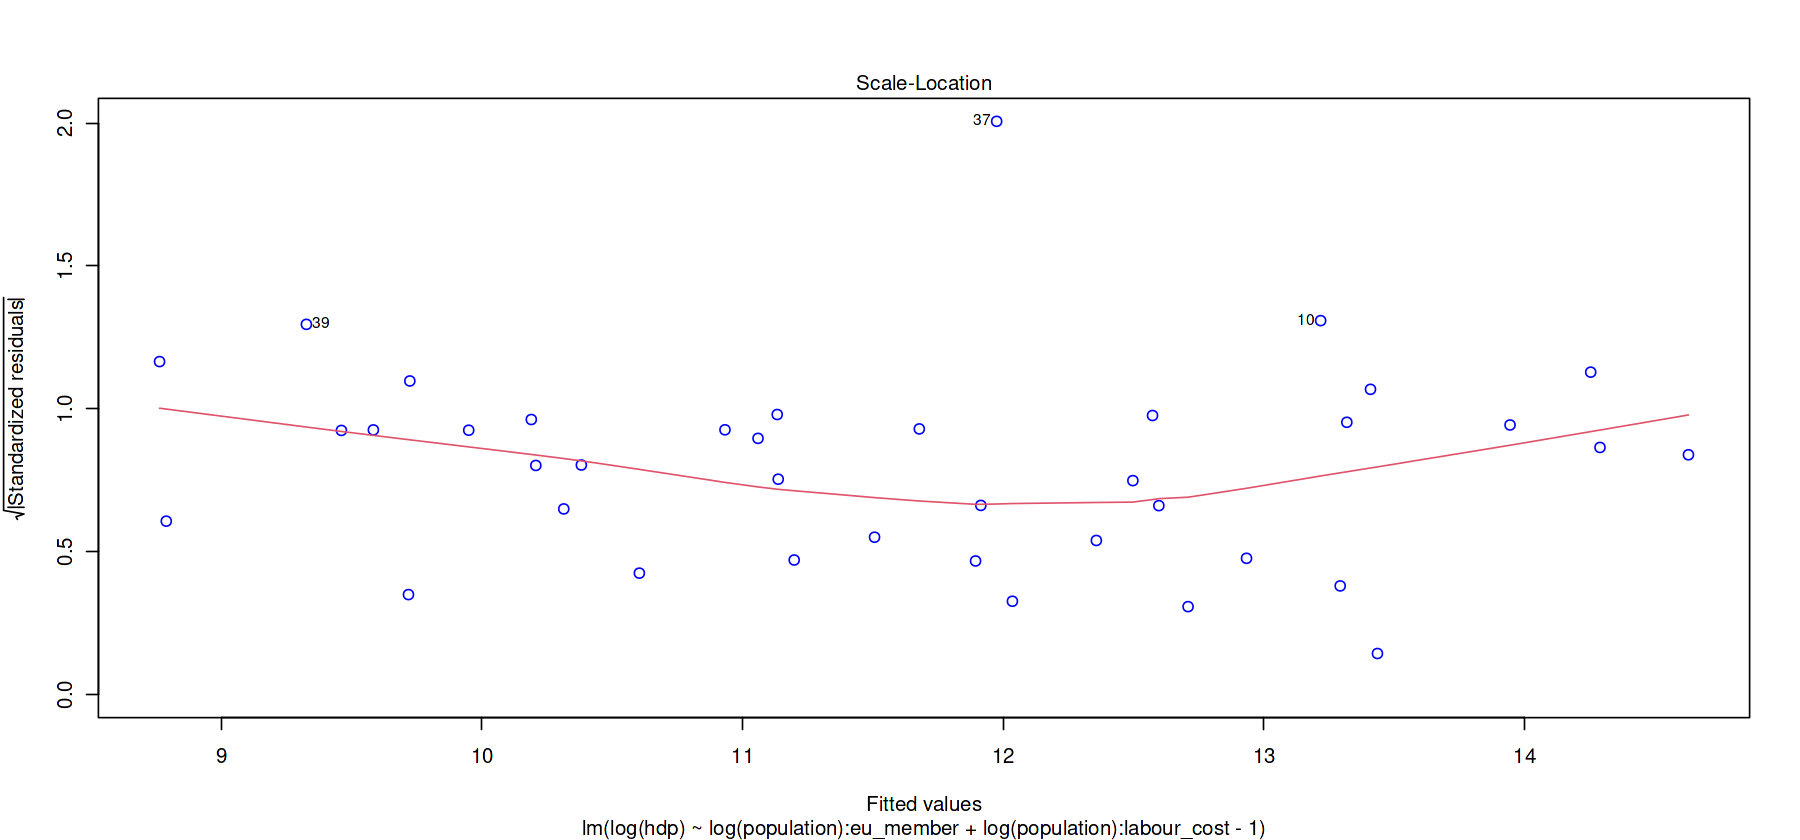

In [60]:
plot(fit8, which=3, col=c("blue"))

In [61]:
ols_test_correlation(fit8)

[1] 0.9419958

Připouštíme, že jsou rezidua normálně rozdělená a že jsou dobře vysvětlena modelem. Úspěšně jsme otestovali všechny přepoklady regresního modelu. 